In [1]:
import scipy
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from functorch import grad, vmap

In [2]:
m = 0.5  # mass of the oscillator
u = 1    # coefficient of friction
k = 50   # spring constant

In [3]:
v0 = np.zeros(2)

# The initial height is 0
v0[0] = 0
# The initial speed is 4
v0[1] = 8

In [4]:
def f(v, t0, k):
    # get position and speed
    x, s = v[0], v[1]
    # calculate acceleration
    a = - (u * s + k * x) / m
    # return v dot
    return np.r_[s, a]

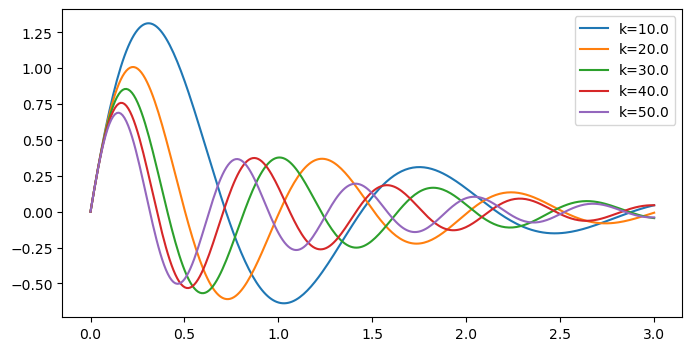

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# We want to evaluate the system on 30 linearly
# spaced times between t=0 and t=3.
t = np.linspace(0., 3., 300)

# We simulate the system for different values of k.
for k in np.linspace(10., 50., 5):
    # We simulate the system and evaluate $v$ on the
    # given times.
    v = scipy.integrate.odeint(f, v0, t, args=(k,))
    # We plot the particle's trajectory.
    ax.plot(t, v[:, 0], '-', mew=1, ms=8,
            mec='w', label=f'k={k:.1f}')
ax.legend()
# ax.set_xlim(0, 12)
# ax.set_ylim(0, 6)

In [6]:
t = np.linspace(0., 3., 300)
v = scipy.integrate.odeint(f, v0, t, args=(k,))

In [7]:
X = t
y = v[:, 0]

In [8]:
X, y = torch.tensor(X, requires_grad=True).float(), torch.tensor(y)

In [9]:
X, y = X.unsqueeze(-1), y.unsqueeze(-1)

In [10]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [21]:
class PINN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.mlp = FCN(1, 1, 32, 3)
        self.m = nn.Parameter(torch.randn(1))
        self.u = nn.Parameter(torch.randn(1))
        self.k = nn.Parameter(torch.randn(1))
    
    def forward(self, t):
        return self.mlp(t)

    def loss(self, X, y):
        p = self.forward(X)
        loss_1 = torch.mean((p - y) ** 2)

        loss_2 = (1e-2) * torch.mean(self._loss_2(X) ** 2)
        return loss_1 + loss_2
    
    def _loss_2(self, t):
        x = self.forward(t)
        
        x_t = torch.autograd.grad(
            x, t, 
            grad_outputs=torch.ones_like(x),
            create_graph=True,
        )[0]

        x_tt = torch.autograd.grad(
            x_t, t, 
            grad_outputs=torch.ones_like(x_t),
            create_graph=True
        )[0]

        return x_tt + self.u * x_t + self.k * x

In [22]:
model = PINN()
op = torch.optim.Adam(model.parameters(), lr=0.005)
for i in range(100000):
    op.zero_grad()
    loss = model.loss(X[::10], y[::10])
    loss.backward()
    op.step()
    if i % 100 == 0:
        print(loss)

tensor(0.1095, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0472, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0463, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0462, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0456, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0455, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0455, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0454, dtype=torch.float64, grad

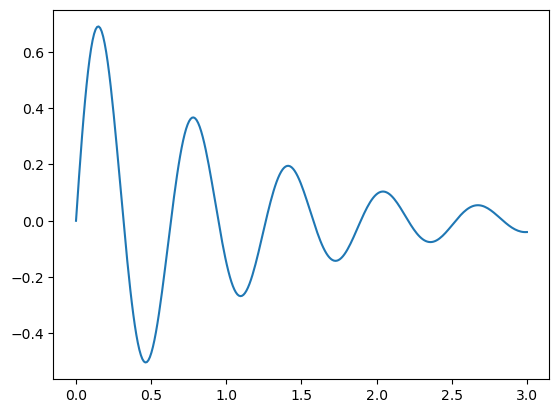

In [23]:
plt.plot(X.squeeze().detach().numpy(), y.squeeze().detach().numpy())

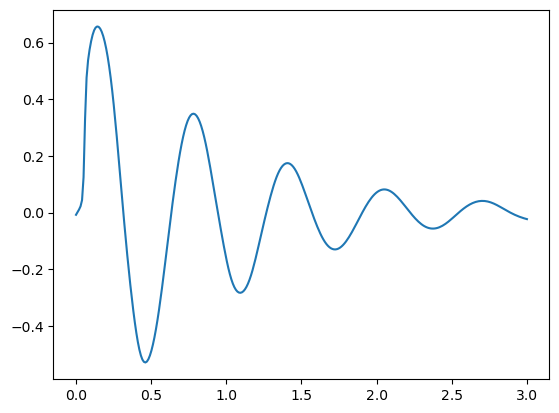

In [24]:
plt.plot(X.squeeze().detach().numpy(), model(X).squeeze().detach().numpy())

In [26]:
print(model.u)

Parameter containing:
tensor([2.3798], requires_grad=True)
